In [3]:
import numpy as np
from math import sin, cos, sqrt
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

###############################################################################
# 1) Define position-dependent hoppings t1(x), t2(x) and derivatives dt1_dx, dt2_dx
###############################################################################

sigma = 1.0  # example exponent

def t1(x):
    # Example: t1(x) = x^sigma (for x > 0)
    if x>0:
        return x**sigma
    return 0.0

def t2(x):
    # Example: t2(x) = 2*x^sigma (for x > 0)
    if x>0:
        return 2.0 * x**sigma
    return 0.0

def dt1_dx(x):
    # derivative of x^sigma => sigma*x^(sigma-1)
    if x>0:
        return sigma * x**(sigma-1)
    return 0.0

def dt2_dx(x):
    # derivative of 2*x^sigma => 2*sigma*x^(sigma-1)
    if x>0:
        return 2.0*sigma * x**(sigma-1)
    return 0.0

###############################################################################
# 2) Define the band energy (for the "+" band) and partial derivatives
###############################################################################

def E_plus(x, p):
    val1 = t1(x)
    val2 = t2(x)
    return sqrt( val1**2 + val2**2 + 2*val1*val2*cos(p) )

def dEplus_dp(x, p):
    # partial derivative of E_plus w.r.t. p
    val1 = t1(x)
    val2 = t2(x)
    denom = E_plus(x, p)
    # derivative wrt p =>  (1/(2 E_+)) * partial_p( val1^2+...+ 2 val1*val2 cos p )
    # but partial_p => -2 val1*val2 sin p
    # => total => [ -2 val1 val2 sin p ] / [2 E_+] = - ( val1 val2 sin p ) / E_+
    if denom == 0.0:
        return 0.0
    return - (val1 * val2 * sin(p)) / denom

def dEplus_dx(x, p):
    # partial derivative of E_plus w.r.t. x
    val1  = t1(x)
    val2  = t2(x)
    dval1 = dt1_dx(x)
    dval2 = dt2_dx(x)
    denom = E_plus(x, p)
    # partial_x( val1^2 + val2^2 + 2 val1 val2 cos p ) =>
    #   2 val1 dval1 + 2 val2 dval2 + 2 cos p [ val1 dval2 + val2 dval1 ]
    # => factor out 2 => 2 [ val1 dval1 + val2 dval2 + cos p( val1 dval2 + val2 dval1 ) ]
    numerator = ( val1*dval1 + val2*dval2 + cos(p)*( val1*dval2 + val2*dval1 ) )
    # => partial_x E => 1/(2 E_+) * 2*( ...)
    # => => [ numerator ] / E_+
    if denom == 0.0:
        return 0.0
    return numerator / denom

###############################################################################
# 3) Build the system: dt/dx = 1 / (dx/dt), dp/dx = dot{p}/dot{x} 
#    where dot{x} = dEplus_dp, dot{p} = - dEplus_dx
###############################################################################

def system_for_t_and_p(x, y):
    """
    We'll treat x as the independent variable.
    y = [ t, p ]  so t = y[0], p = y[1].

    Then:
      dt/dx = 1 / (dx/dt) = 1 / dEplus_dp(x, p)
      dp/dx = dot{p}/dot{x} = [ - dEplus_dx(x, p ) ] / [ dEplus_dp(x, p) ]
    """
    t, p = y
    dxdt = dEplus_dp(x, p)   # = partial E_+ / partial p
    if abs(dxdt) < 1e-14:
        # avoid division by zero if sin p=0 => turning point
        return [ 1e10, 0.0 ]  # or something big

    dt_dx = 1.0 / dxdt
    dp_dx = - dEplus_dx(x, p ) / dxdt

    return [ dt_dx, dp_dx ]

###############################################################################
# 4) Initial conditions & integration
###############################################################################
x0  = 0.8            # initial position
p0  = -0.7 * np.pi/2 # initial momentum, e.g. 
t0  = 0.0            # we define time=0 at x(0)=0.8

# We also define an endpoint for x, e.g. x_min if we know it, or we pick a guess.
# For demonstration, let's assume we want to integrate until x=0.1 
# (or you can use your turning-point formula).
x_end = 0.1  

# We'll store [ t(x), p(x) ] with y0 = [ t0, p0 ] at x=x0
y0   = [ t0, p0 ]

sol = solve_ivp(
    fun=system_for_t_and_p,
    t_span=(x0, x_end),   # we integrate from x=0.8 down to x=0.1
    y0=y0,
    dense_output=True,
    max_step=1e-3
)

# We'll sample
num_points = 301
xs = np.linspace(x0, x_end, num_points)
solY = sol.sol(xs)   # shape is (2, len(xs))
ts = solY[0,:]
ps = solY[1,:]

###############################################################################
# 5) Make a plot with x on horizontal axis, t on vertical axis (like figure 3)
###############################################################################
plt.figure(figsize=(6,5))
plt.plot(xs, ts, label='t(x)')
plt.xlabel('position x')
plt.ylabel('time t')
plt.title('Time vs. Position (x as independent variable)')
plt.legend()
plt.grid(True)
plt.show()

###############################################################################
# Optionally plot p(x)


KeyboardInterrupt: 

In [ ]:
import numpy as np
from math import sin, cos, sqrt
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

###############################################################################
# 1) Set model parameters, initial x0, p0, etc.
###############################################################################

# We define a single-power-law style for t1(x), t2(x)
#   t1(x) = A*x^sigma,   t2(x) = B*x^sigma
# as an example.
# If you have a more complex form, adapt accordingly.

sigma = 1.0       # exponent
A = 1.0
B = 2.0

x0 = 0.8          # initial position
p0 = -0.7*np.pi/2 # initial momentum
t0 = 0.0          # we'll set time = 0 at x = x0

###############################################################################
# 2) Define t1(x), t2(x), dt1_dx(x), dt2_dx(x)
###############################################################################
def t1_of_x(x):
    return A*(x**sigma) if x>0 else 0.0

def t2_of_x(x):
    return B*(x**sigma) if x>0 else 0.0

def dt1_dx(x):
    # derivative wrt x => A*sigma*x^(sigma-1)
    if x>0:
        return A*sigma*(x**(sigma-1))
    return 0.0

def dt2_dx(x):
    # derivative wrt x => B*sigma*x^(sigma-1)
    if x>0:
        return B*sigma*(x**(sigma-1))
    return 0.0

###############################################################################
# 3) The "plus" band energy E_+, partial derivatives
###############################################################################
def E_plus(x, p):
    val1 = t1_of_x(x)
    val2 = t2_of_x(x)
    return sqrt(val1**2 + val2**2 + 2.*val1*val2*cos(p))

def dEplus_dp(x, p):
    denom = E_plus(x, p)
    if denom == 0.0:
        return 0.0
    val1 = t1_of_x(x)
    val2 = t2_of_x(x)
    return -(val1*val2*sin(p))/denom

def dEplus_dx(x, p):
    denom = E_plus(x, p)
    if denom == 0.0:
        return 0.0
    val1  = t1_of_x(x)
    val2  = t2_of_x(x)
    dval1 = dt1_dx(x)
    dval2 = dt2_dx(x)
    return ( val1*dval1 + val2*dval2 
             + cos(p)*( val1*dval2 + val2*dval1 ) ) / denom

###############################################################################
# 4) The system in x as independent variable: 
#    dt/dx = 1 / (dx/dt),  dp/dx = dot{p}/dot{x}
###############################################################################
def system_t_p(x, y):
    """
    We'll treat 'x' as the independent variable.
    y = [t, p].
    Then:
      dt/dx = 1 / (dx/dt) = 1 / dEplus_dp(x, p)
      dp/dx = [ -dEplus_dx(x, p ) ] / [ dEplus_dp(x, p) ]
    """
    t, p = y
    dxdt = dEplus_dp(x, p)  # = partial E_+ / partial p
    eps = 1e-14
    if abs(dxdt)<eps:
        # turning point or dxdt ~ 0 => handle carefully 
        # (return a big dt/dx, dp/dx=0) or do what you want:
        return [1e10, 0.0]  
    dt_dx = 1.0/dxdt
    dp_dx = - dEplus_dx(x, p)/dxdt
    return [ dt_dx, dp_dx ]

###############################################################################
# 5) Evaluate t1,t2 at x0, then build the x_min formula 
#    x_min= x0*( A + B - A B )^(1/(2*sigma)), 
#    where A= ((t2-t1)/(t2+t1))^2, B= cos^2(p0).
###############################################################################

t1x0 = t1_of_x(x0)
t2x0 = t2_of_x(x0)
cos_p0 = cos(p0)

# A = ((t2 - t1)/(t2 + t1))^2
# B = (cos p0)^2
# inside => A + B - A*B
# then raised to 1/(2*sigma)
num = (t2x0 - t1x0)
den = (t2x0 + t1x0)
if abs(den)<1e-14:
    print("Warning: t1 + t2 ~ 0 => formula might blow up.")
A_ = (num/den)**2
B_ = (cos_p0)**2
temp = A_ + B_ - A_*B_
if temp<0:
    print("Warning: expression < 0 => check your formula or sign.")
# x_min = x0 * (temp)^(1/(2*sigma))
x_min = x0 * (temp**(1.0/(2.0*sigma)))

print(f"Using turning point formula => x_min = {x_min}")

###############################################################################
# 6) Integrate from x0 to x_min 
###############################################################################
# If x_min < x0, we do (x0, x_min). If x_min> x0, do (x0,x_min) or vice versa. 
# We'll handle sign:

left_bound, right_bound = (x0, x_min) if (x_min> x0) else (x_min, x0)

y0 = [ t0, p0 ]

sol = solve_ivp(
    fun=system_t_p,
    t_span=(left_bound, right_bound),
    y0=y0,
    dense_output=True,
    max_step=1e-3
)

###############################################################################
# 7) Sample the solution and plot: x on horizontal, t on vertical
###############################################################################
xs = np.linspace(left_bound, right_bound, 301)
solY = sol.sol(xs)
ts = solY[0,:]
ps = solY[1,:]

plt.figure(figsize=(6,5))
plt.plot(xs, ts, label='t(x)')
plt.xlabel('position x')
plt.ylabel('time t')
plt.title('Time vs. position (x as indep. var.)')
plt.grid(True)
plt.legend()
plt.show()

# Optionally, plot p(x):
plt.figure()
plt.plot(xs, ps, label='p(x)', color='red')
plt.xlabel('x')
plt.ylabel('p')
plt.title('p vs x')
plt.grid(True)
plt.legend()
plt.show()


Initial energy E0 = 26.457513110645905
Analytical turning point x_min = 5.773502691896258
Integration stopped at time t = 100.0
x(t) reached turning point x_min = 25.653759384813547


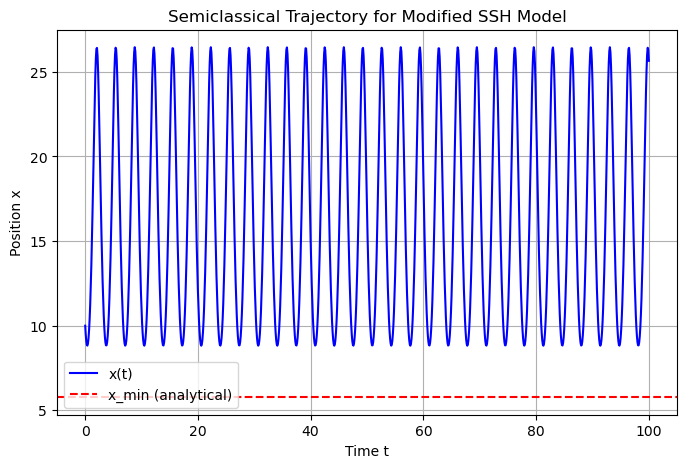

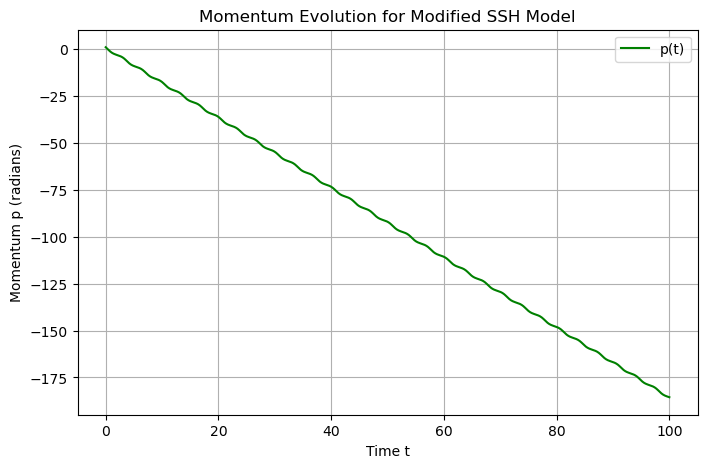

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Parameters for the modified SSH model:
A = 1.0          # constant for t1(x)
B = 2.0          # constant for t2(x)
sigma = 1.0      # power-law exponent (sigma)
dx = 1.0         # lattice spacing (set to 1)

# Initial conditions:
x0 = 10.0        # initial position
p0 = np.pi / 3   # initial momentum (in radians)

# Define the hopping functions and their derivatives.
def t1(x):
    return A * x**sigma

def t2(x):
    return B * x**sigma

def dt1_dx(x):
    return A * sigma * x**(sigma - 1)

def dt2_dx(x):
    return B * sigma * x**(sigma - 1)

# Compute the conserved energy from the initial condition.
E0 = np.sqrt(t1(x0)**2 + t2(x0)**2 + 2 * t1(x0) * t2(x0) * np.cos(p0))
print("Initial energy E0 =", E0)

# Define the right-hand side of the ODE system.
def ssh_odes(t, y):
    x, p = y
    # Evaluate hoppings and derivatives at current x
    t1_val = t1(x)
    t2_val = t2(x)
    dt1 = dt1_dx(x)
    dt2 = dt2_dx(x)
    # Using the constant E0 in the denominator (energy conservation)
    dxdt = - (t1_val * t2_val * np.sin(p)) / E0
    dpdt = - (t1_val * dt1 + t2_val * dt2 + np.cos(p) * (dt1 * t2_val + t1_val * dt2)) / E0
    return [dxdt, dpdt]

# Define the turning point x_min using the given analytical expression.
# Here we evaluate t1 and t2 at x0.
ratio = (t2(x0) - t1(x0)) / (t2(x0) + t1(x0))
x_min = x0 * ((ratio**2 + np.cos(p0)**2 - (ratio**2) * (np.cos(p0)**2))**(1/(2 * sigma)))
print("Analytical turning point x_min =", x_min)

# We'll integrate until x reaches x_min. Since our ODE solver integrates with respect to time,
# we define an event that stops integration when x - x_min becomes zero (from above).
def event_turning_point(t, y):
    x, _ = y
    return x - x_min
event_turning_point.terminal = True
event_turning_point.direction = -1  # Expect x to decrease toward x_min

# Time span for integration (choose a sufficiently long final time)
t_span = (0, 100)
y0 = [x0, p0]

sol = solve_ivp(ssh_odes, t_span, y0, events=event_turning_point, dense_output=True, max_step=0.1)

# Extract the solution
t_vals = sol.t
x_vals = sol.y[0]
p_vals = sol.y[1]

print("Integration stopped at time t =", t_vals[-1])
print("x(t) reached turning point x_min =", x_vals[-1])

# Plot the trajectory x(t)
plt.figure(figsize=(8, 5))
plt.plot(t_vals, x_vals, 'b-', label='x(t)')
plt.axhline(x_min, color='r', linestyle='--', label='x_min (analytical)')
plt.xlabel('Time t')
plt.ylabel('Position x')
plt.title('Semiclassical Trajectory for Modified SSH Model')
plt.legend()
plt.grid(True)
plt.show()

# Plot p(t)
plt.figure(figsize=(8, 5))
plt.plot(t_vals, p_vals, 'g-', label='p(t)')
plt.xlabel('Time t')
plt.ylabel('Momentum p (radians)')
plt.title('Momentum Evolution for Modified SSH Model')
plt.legend()
plt.grid(True)
plt.show()


Initial energy E0 = -1.0514622242382672
Analytical turning point x_min = 0.276393202250021
Integration stopped at time t = 4.0
x reached turning point x_min = 7.52931078566782


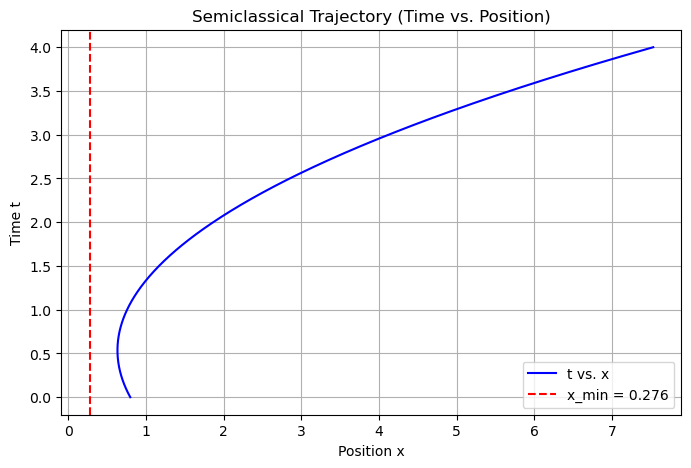

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# ----- Model Parameters -----
# Constants for the hopping functions (t1 and t2 are constant prefactors)
A = 1.0          # constant multiplier for t1
B = 1.0          # constant multiplier for t2
sigma = 0.5      # power-law exponent

# Define the hopping functions:
def t1(x):
    return A * x**sigma

def t2(x):
    return B * x**sigma

# Their spatial derivatives:
def dt1_dx(x):
    return A * sigma * x**(sigma - 1)

def dt2_dx(x):
    return B * sigma * x**(sigma - 1)

# ----- Initial Conditions -----
x0 = 0.8         # initial position
p0 = -0.6*np.pi / 2   # initial momentum (in radians)
t0 = 0           # initial time

# ----- Compute the Conserved Energy -----
# Energy: E(x,p) = x^sigma * sqrt( A^2 + B^2 + 2 A B cos(p) )
#E0 = x0**sigma * np.sqrt( A**2 + B**2 + 2 * A * B * np.cos(p0) )
E0= -2*x0**sigma*np.cos(p0)
print("Initial energy E0 =", E0)

# ----- Analytical Turning Point x_min -----
# Given formula:
#   x_min = x0 * { ((B-A)/(B+A))^2 + cos^2(p0) - ((B-A)/(B+A))^2 * cos^2(p0) }^(1/(2*sigma))
ratio = (B - A) / (B + A)
x_min = x0 * ( (ratio**2 + np.cos(p0)**2 - (ratio**2)*(np.cos(p0)**2) )**(1.0/(2*sigma)) )
print("Analytical turning point x_min =", x_min)

# ----- Define the ODE system -----
# Semiclassical equations (with dx=1)
# dx/dt = -[t1(x)*t2(x)*sin(p)]/E0
# dp/dt = -[t1(x)*dt1_dx(x) + t2(x)*dt2_dx(x) + cos(p)*(t1(x)*dt2_dx(x)+dt1_dx(x)*t2(x))] / E0
def ssh_odes(t, y):
    x, p = y
    t1_val = t1(x)
    t2_val = t2(x)
    dt1_val = dt1_dx(x)
    dt2_val = dt2_dx(x)
    dxdt = -(t1_val * t2_val * np.sin(p)) / E0
    dpdt = -( t1_val * dt1_val + t2_val * dt2_val + np.cos(p)*(t1_val * dt2_val + dt1_val * t2_val) ) / E0
    return [dxdt, dpdt]

# ----- Define an Event to Stop at x_min -----
def event_turning_point(t, y):
    x, _ = y
    return x - x_min  # event when x equals x_min
event_turning_point.terminal = True
# Expect x to decrease from x0 down to x_min:
event_turning_point.direction = -1

# ----- Integrate the ODE System -----
# We integrate in time until the event is triggered.
t_span = (t0, 4)
y0 = [x0, p0]

sol = solve_ivp(ssh_odes, t_span, y0, events=event_turning_point, dense_output=True, max_step=0.01)

t_vals = sol.t       # times
x_vals = sol.y[0]    # positions
p_vals = sol.y[1]    # momenta

print("Integration stopped at time t =", t_vals[-1])
print("x reached turning point x_min =", x_vals[-1])

# ----- Plot: Time (vertical) vs. Position (horizontal) -----
plt.figure(figsize=(8,5))
plt.plot(x_vals, t_vals, 'b-', label='t vs. x')
plt.xlabel('Position x')
plt.ylabel('Time t')
plt.title('Semiclassical Trajectory (Time vs. Position)')
plt.axvline(x=x_min, color='r', linestyle='--', label=f'x_min = {x_min:.3f}')
plt.legend()
plt.grid(True)
plt.show()


Numerical turning point (x_min) = 0.001983001741333082
Analytical turning point x_min = 4.898587196589413e-17


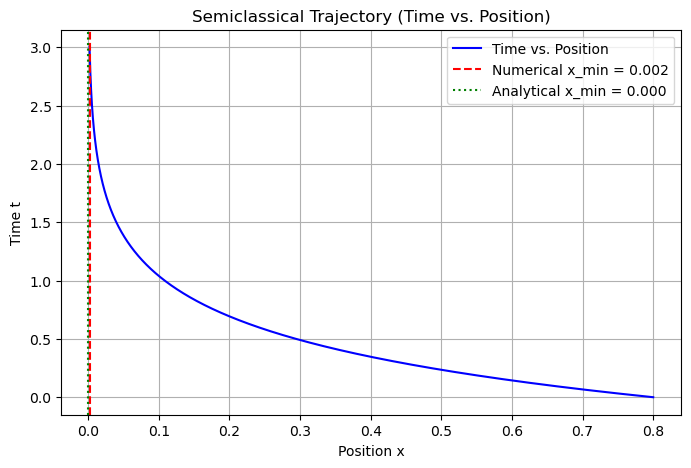

In [ ]:
#Correct result for  CST Tight binding model  !!!
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# ---------------------
# Model parameters from the SciPost paper Fig.4(b)
gamma = 1          # (sigma in your earlier code; here gamma)
x0 = 0.8             # initial position
p0 =- 1 * (np.pi/2) # initial momentum in radians (~0.9425)
t0 = 0               # initial time

# ---------------------
# Semiclassical ODE system for the single-hopping model:
#   E(x,p) = -2 * x^gamma * cos p
# Thus,
#   dx/dt = 2 * x^gamma * sin p
#   dp/dt = -2 * gamma * x^(gamma-1) * cos p
def odefun(t, y):
    x, p = y
    dxdt = 2.0 * (x**gamma) * np.sin(p)
    dpdt = 2.0 * gamma * (x**(gamma - 1.0)) * np.cos(p)
    return [dxdt, dpdt]

# ---------------------
# Set up integration:
t_span = (t0, 3)   # integrate from t=0 to t=20 (sufficient to see the turning behavior)
y0 = [x0, p0]

# Integrate the ODE system with a small max_step for accuracy.
sol = solve_ivp(odefun, t_span, y0, dense_output=True, max_step=0.001)

# Extract the solution arrays:
t_vals = sol.t         # time points
x_vals = sol.y[0]      # positions x(t)
p_vals = sol.y[1]      # momenta p(t)

# ---------------------
# Compute the numerical turning point as the minimum x value:
x_min_num = np.min(x_vals)
print("Numerical turning point (x_min) =", x_min_num)

# ---------------------
# Compute the analytical turning point:
# From energy conservation:
#   -2*x0^gamma*cos(p0) = -2*x_min^gamma  =>  x_min = x0*(cos(p0))^(1/gamma)
x_min_analytic = x0 * (np.cos(p0))**(1/gamma)
print("Analytical turning point x_min =", x_min_analytic)

# ---------------------
# Plot: Time (vertical axis) vs. Position (horizontal axis)
plt.figure(figsize=(8,5))
plt.plot(x_vals, t_vals, 'b-', label='Time vs. Position')
plt.xlabel('Position x')
plt.ylabel('Time t')
plt.title('Semiclassical Trajectory (Time vs. Position)')
plt.axvline(x=x_min_num, color='r', linestyle='--', label=f'Numerical x_min = {x_min_num:.3f}')
plt.axvline(x=x_min_analytic, color='g', linestyle=':', label=f'Analytical x_min = {x_min_analytic:.3f}')
plt.legend()
plt.grid(True)
plt.show()


Numerical turning point x_min = 0.6417095768747973


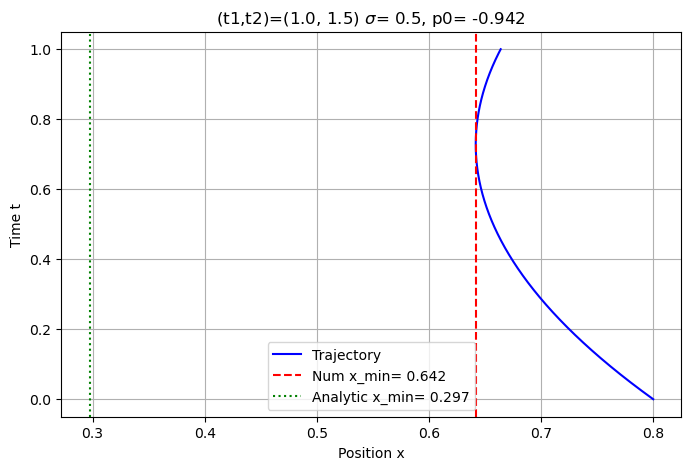

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

###############################################################################
# User choices:
###############################################################################
model_type = 'modified'     # 'single' or 'modified'
gamma      = 0.5          # exponent
x0         = 0.8          # initial position
p0         = -0.6 * np.pi/2  # initial momentum
t_span     = (0, 1)      # integrate time from 0 to 10
max_step   = 0.001        # smaller = more accurate

# For the modified SSH model:
A = 1.0   # amplitude for t1(x) = A * x^gamma
B = 1.5   # amplitude for t2(x) = B * x^gamma

###############################################################################
# Define the ODE system, picking the formula based on model_type
###############################################################################

def single_hopping_odes(t, y):
    """ ODEs for E(x,p) = -2 x^gamma cos p. """
    x, p = y
    dxdt = 2.0 * (x**gamma) * np.sin(p)
    dpdt = 2.0 * gamma * (x**(gamma - 1.0)) * np.cos(p)
    return [dxdt, dpdt]

def modified_ssh_odes(t, y):
    """
    ODEs for
      E(x,p) = - sqrt( t1(x)^2 + t2(x)^2 + 2 t1(x) t2(x) cos p ).
    with t1(x)=A x^gamma, t2(x)=B x^gamma.
    """
    x, p = y
    # T1, T2:
    t1_val = A * (x**gamma)
    t2_val = B * (x**gamma)
    # Derivatives wrt x:
    dt1_val = A * gamma * (x**(gamma - 1))
    dt2_val = B * gamma * (x**(gamma - 1))

    denom = np.sqrt(A**2 + B**2 + 2*A*B*np.cos(p0))

    # dx/dt = partial E / partial p:
    # E = - denom => partial_E/partial_p = - partial_denom/partial_p
    # partial_denom wrt p = - [ t1_val t2_val sin(p) / denom ]
    # => so dxdt = -( - t1_val t2_val sin p / denom ) = t1_val t2_val sin p / denom
    # but there's a minus sign in front from E= - denom => double-check:
    #   E = - denom => dE/dp = -( d(d)/dp )
    #   d(d)/dp = ( t1 t2 (-sin p) ) / denom
    # => partial_E/partial_p = - [ t1_val t2_val (-sin p) / denom ] = + t1_val t2_val sin p / denom
    dxdt = t1_val * t2_val * np.sin(p) / denom

    # dp/dt = - partial E / partial x
    # partial E/partial x = - partial denom/partial x
    # partial denom/partial x = (1/denom) [ t1_val dt1_val + t2_val dt2_val
    #                 + cos p ( dt1_val t2_val + t1_val dt2_val ) ]
    # => partial E/partial x = - ( that ), dp/dt = - partial E/partial x
    # => dpdt = + ( that ), let's do carefully:
    ddx = (t1_val*dt1_val + t2_val*dt2_val
           + np.cos(p)*(dt1_val*t2_val + t1_val*dt2_val) ) / denom

    # E= - denom => partial_E/partial_x = - partial denom/partial x => partial denom/partial x = ddx
    # => partial_E/partial_x = - ddx, => dp/dt = - partial_E/partial_x = ddx
    dpdt = ddx

    return [dxdt, dpdt]

###############################################################################
# ODE function chosen by model_type
###############################################################################

def combined_odes(t, y):
    if model_type == 'single':
        return single_hopping_odes(t, y)
    elif model_type == 'modified':
        return modified_ssh_odes(t, y)
    else:
        raise ValueError("Unknown model_type: choose 'single' or 'modified'.")

###############################################################################
# Integrate the chosen system
###############################################################################
y0 = [x0, p0]
sol = solve_ivp(combined_odes, t_span, y0, dense_output=True, max_step=max_step)

t_vals = sol.t
x_vals = sol.y[0]
p_vals = sol.y[1]

###############################################################################
# Find turning point (numerical minimum of x)
###############################################################################
x_min_num = np.min(x_vals)

###############################################################################
# Possibly compute an *analytical* turning point if model_type='single'
###############################################################################
if model_type == 'single':
    # E= -2 x^gamma cos p => turning point => p=0 => or sin p=0 => let's do the p=0 approach:
    # from energy conservation:
    # -2 x0^gamma cos p0 = -2 x_min^gamma => x_min= x0 (cos p0)^(1/gamma)
    x_min_analytic = x0 * (np.cos(p0))**(1.0/gamma)
    print("Analytical turning point (single-hop) x_min=", x_min_analytic)
    x_min_analytic_label = f"Analytic x_min= {x_min_analytic:.3f}"
else:
    x_min_analytic = x0*((np.cos(p0))**(2)+((B/A-1)/(B/A+1))**(2)-(np.cos(p0))**(2)*((B/A-1)/(B/A+1))**(2))**(1/(2*gamma))
    x_min_analytic_label = f"Analytic x_min= {x_min_analytic:.3f}"

print("Numerical turning point x_min =", x_min_num)

###############################################################################
# Plot Time (vertical) vs. Position x (horizontal)
###############################################################################
plt.figure(figsize=(8,5))
plt.plot(x_vals, t_vals, 'b-', label='Trajectory')
plt.axvline(x=x_min_num, color='r', linestyle='--', label=f'Num x_min= {x_min_num:.3f}')

if model_type == 'single':
    plt.axvline(x=x_min_analytic, color='g', linestyle=':', label=x_min_analytic_label)
else:
    plt.axvline(x=x_min_analytic, color='g', linestyle=':', label=x_min_analytic_label)
plt.xlabel('Position x')
plt.ylabel('Time t')
plt.title(f"(t1,t2)={A,B} $\sigma$= {gamma}, p0= {p0:.3f}")
plt.legend()
plt.grid(True)
plt.show()


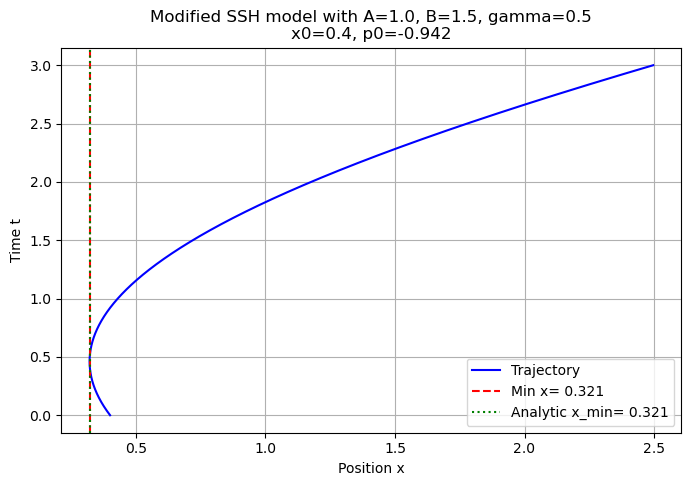

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

###############################################################################
# Parameters for the "modified SSH" model
###############################################################################
A     = 1.0       # prefactor for t1(x) = A * x^gamma
B     = 1.5       # prefactor for t2(x) = B * x^gamma
gamma = 0.5       # exponent for x^gamma
x0    = .4       # initial position
p0    = -0.6* np.pi/2  # initial momentum (in radians)
t_span= (0, 3)   # integrate from t=0 to t=10
max_step = 0.001  # step size for the ODE solver

###############################################################################
# Define the hopping functions t1(x), t2(x) and their derivatives wrt x
###############################################################################
def t1(x):
    return A * (x**gamma)

def t2(x):
    return B * (x**gamma)

def dt1_dx(x):
    return A * gamma * (x**(gamma - 1.0))

def dt2_dx(x):
    return B * gamma * (x**(gamma - 1.0))

###############################################################################
# Semiclassical ODE system for the "modified SSH" band:
# E(x,p) = - sqrt( t1(x)^2 + t2(x)^2 + 2 t1(x)*t2(x)*cos p )
#
# => partial E / partial p, partial E / partial x
# We'll define:
#   dot{x} = dE/dp,   dot{p} = - dE/dx
###############################################################################
def modified_ssh_odes(t, y):
    x, p = y

    t1_val = t1(x)
    t2_val = t2(x)
    dt1_val = dt1_dx(x)
    dt2_val = dt2_dx(x)

    # denom = sqrt(t1^2 + t2^2 + 2 t1 t2 cos p)
    #denom = np.sqrt(A**2 + B**2 + 2*A*B*np.cos(p0))
    denom = np.sqrt(t1_val**2 + t2_val**2 + 2*t1_val*t2_val*np.cos(p))


    # E = - denom
    # partial E / partial p = -( partial denom / partial p )
    # partial denom/partial p = (1/denom)* [ t1_val t2_val (-sin p) ]
    # => = t1_val t2_val (-sin p)/denom
    #
    # => partial E/partial p = - [ t1_val t2_val (- sin p)/denom ] = + t1_val t2_val sin p/denom
    dxdt = (t1_val * t2_val * np.sin(p)) / denom

    # partial E/partial x = -( partial denom / partial x )
    # partial denom/partial x = (1/denom)* [ t1_val dt1_val + t2_val dt2_val
    #                      + cos p ( dt1_val t2_val + t1_val dt2_val ) ]
    # => partial E/partial x = - that => dp/dt = - partial E/partial x = + that
    ddx = (t1_val*dt1_val + t2_val*dt2_val
           + np.cos(p)*(dt1_val*t2_val + t1_val*dt2_val)) / denom

    dpdt = ddx

    return [dxdt, dpdt]

###############################################################################
# Integrate the system using solve_ivp
###############################################################################
y0 = [x0, p0]
sol = solve_ivp(modified_ssh_odes, t_span, y0, dense_output=True, max_step=max_step)

t_vals = sol.t
x_vals = sol.y[0]
p_vals = sol.y[1]

# We can find the minimal x(t) as a rough turning point, though it's not strictly guaranteed
x_min_num = np.min(x_vals)
#x_min_analytic = x0*((np.cos(p0))**(2)+((B/A-1)/(B/A+1))**(2)-(np.cos(p0))**(2)*((B/A-1)/(B/A+1))**(2))**(1/(2*gamma))
# Check sign if you guess p_min=0:
x_min_analytic = x0 * (np.sqrt(A**2 + B**2 + 2*A*B*np.cos(p0)) / (A + B))**(1/gamma)

x_min_analytic_label = f"Analytic x_min= {x_min_analytic:.3f}"


###############################################################################
# Plot: Time (vertical) vs. Position x (horizontal)
###############################################################################
plt.figure(figsize=(8,5))
plt.plot(x_vals, t_vals, 'b-', label='Trajectory')
plt.axvline(x=x_min_num, color='r', linestyle='--', label=f'Min x= {x_min_num:.3f}')
plt.axvline(x=x_min_analytic, color='g', linestyle=':', label=x_min_analytic_label)
plt.xlabel('Position x')
plt.ylabel('Time t')
plt.title(f"Modified SSH model with A={A}, B={B}, gamma={gamma}\n"
          f"x0={x0}, p0={p0:.3f}")
plt.legend()
plt.grid(True)
plt.show()


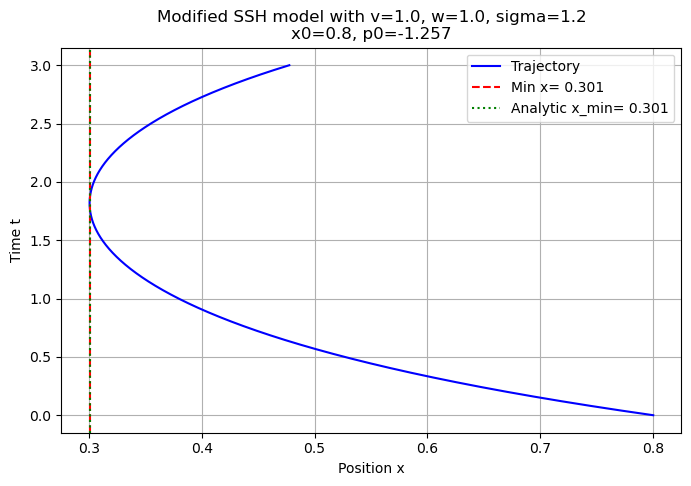

In [129]:
#you can tweak

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

###############################################################################
# Parameters for the "modified SSH" model
###############################################################################
v     = 1.0       # prefactor for t1(x) = A * x^gamma
w     = 1.0       # prefactor for t2(x) = B * x^gamma
sigma = 1.2      # exponent for x^gamma
x0    = .8       # initial position
p0    = -0.8* np.pi/2  # initial momentum (in radians)
t_span= (0, 3)   # integrate from t=0 to t=10
max_step = 0.001  # step size for the ODE solver

###############################################################################
# Define the hopping functions t1(x), t2(x) and their derivatives wrt x
###############################################################################
def t1(x):
    return v * (x**sigma)

def t2(x):
    return w * (x**sigma)

def dt1_dx(x):
    return v * sigma * (x**(sigma - 1.0))

def dt2_dx(x):
    return w * sigma * (x**(sigma - 1.0))

###############################################################################
# Semiclassical ODE system for the "modified SSH" band:
# E(x,p) = - sqrt( t1(x)^2 + t2(x)^2 + 2 t1(x)*t2(x)*cos p )
#
# => partial E / partial p, partial E / partial x
# We'll define:
#   dot{x} = dE/dp,   dot{p} = - dE/dx
###############################################################################
def modified_ssh_odes(t, y):
    x, p = y

    t1_val = t1(x)
    t2_val = t2(x)
    dt1_val = dt1_dx(x)
    dt2_val = dt2_dx(x)

    # denom = sqrt(t1^2 + t2^2 + 2 t1 t2 cos p)
    #denom = np.sqrt(A**2 + B**2 + 2*A*B*np.cos(p0))
    denom = np.sqrt(t1_val**2 + t2_val**2 + 2*t1_val*t2_val*np.cos(2*p))


    # E = - denom
    # partial E / partial p = -( partial denom / partial p )
    # partial denom/partial p = (1/denom)* [ t1_val t2_val (-sin p) ]
    # => = t1_val t2_val (-sin p)/denom
    #
    # => partial E/partial p = - [ t1_val t2_val (- sin p)/denom ] = + t1_val t2_val sin p/denom
    dxdt = (t1_val * t2_val * np.sin(2*p)) / denom

    # partial E/partial x = -( partial denom / partial x )
    # partial denom/partial x = (1/denom)* [ t1_val dt1_val + t2_val dt2_val
    #                      + cos p ( dt1_val t2_val + t1_val dt2_val ) ]
    # => partial E/partial x = - that => dp/dt = - partial E/partial x = + that
    ddx = (t1_val*dt1_val + t2_val*dt2_val
           + np.cos(2*p)*(dt1_val*t2_val + t1_val*dt2_val)) / denom

    dpdt = 0.5*ddx

    return [dxdt, dpdt]

###############################################################################
# Integrate the system using solve_ivp
###############################################################################
y0 = [x0, p0]
sol = solve_ivp(modified_ssh_odes, t_span, y0, dense_output=True, max_step=max_step)

t_vals = sol.t
x_vals = sol.y[0]
p_vals = sol.y[1]

# We can find the minimal x(t) as a rough turning point, though it's not strictly guaranteed
x_min_num = np.min(x_vals)
#x_min_analytic = x0*((np.cos(p0))**(2)+((B/A-1)/(B/A+1))**(2)-(np.cos(p0))**(2)*((B/A-1)/(B/A+1))**(2))**(1/(2*gamma))
# Check sign if you guess p_min=0:
x_min_analytic = x0 * (np.sqrt(v**2 + w**2 + 2*v*w*np.cos(2*p0)) / (v + w))**(1/sigma)

x_min_analytic_label = f"Analytic x_min= {x_min_analytic:.3f}"


###############################################################################
# Plot: Time (vertical) vs. Position x (horizontal)
###############################################################################
plt.figure(figsize=(8,5))
plt.plot(x_vals, t_vals, 'b-', label='Trajectory')
plt.axvline(x=x_min_num, color='r', linestyle='--', label=f'Min x= {x_min_num:.3f}')
plt.axvline(x=x_min_analytic, color='g', linestyle=':', label=x_min_analytic_label)
plt.xlabel('Position x')
plt.ylabel('Time t')
plt.title(f"Modified SSH model with v={v}, w={w}, sigma={sigma}\n"
          f"x0={x0}, p0={p0:.3f}")
plt.legend()
plt.grid(True)
plt.show()


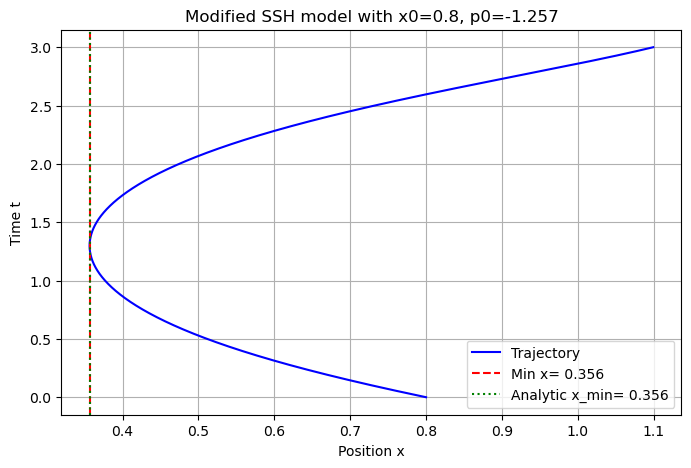

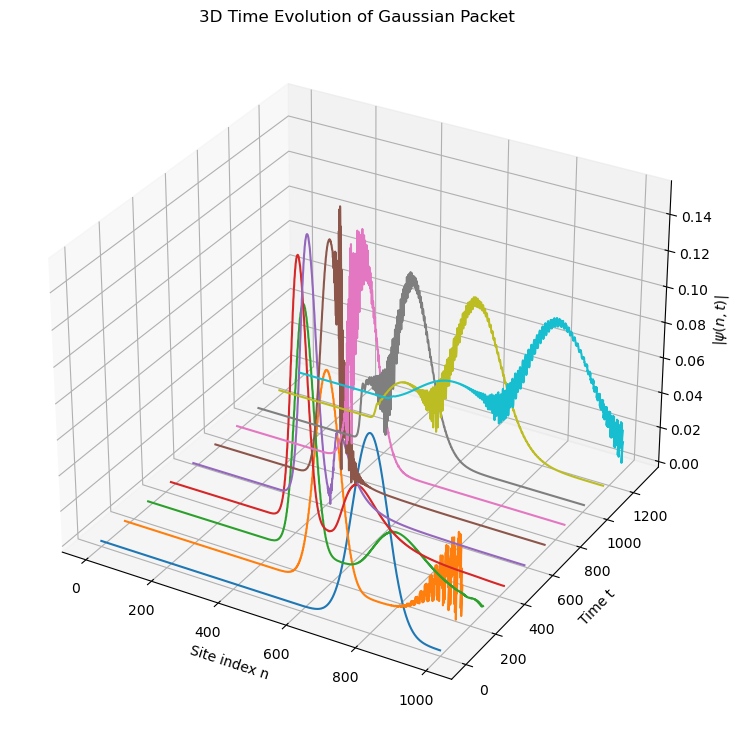

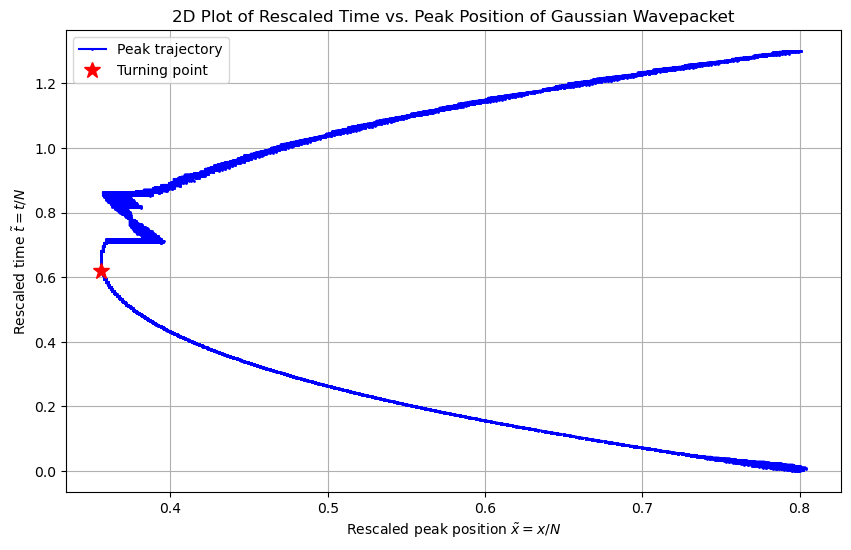

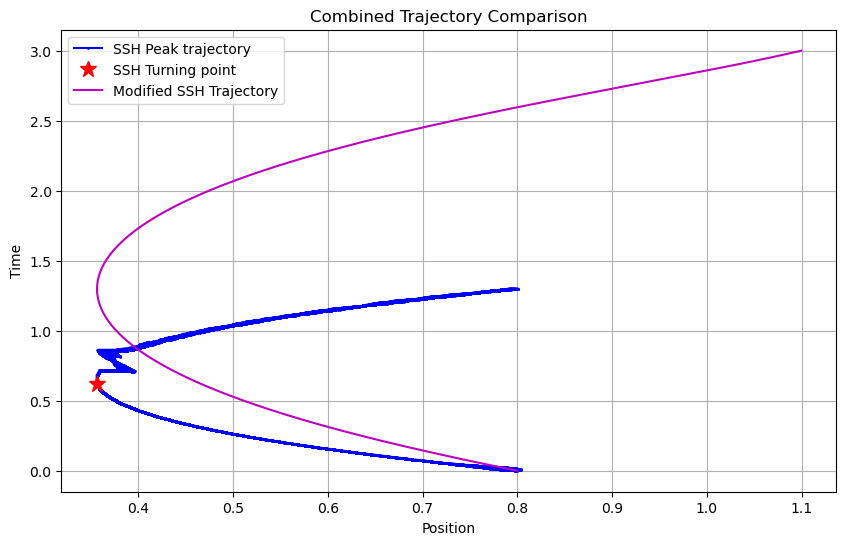

In [93]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D  # 3D plotting toolkit

###############################################################################
# 1st Code: SSH Time evolution (unchanged)
###############################################################################
def build_ssh_hamiltonian(N, v, w, sigma):
    """
    Build the SSH Hamiltonian on a 1D lattice of N sites.
    """
    H = np.zeros((N, N), dtype=complex)
    for i in range(N-1):
        # Scale the hopping amplitudes with position
        v_i = v * ((i + 1) / (N-1))**sigma
        w_i = w * ((i + 1) / (N-1))**sigma
        if i % 2 == 0:
            H[i, i+1] = -v_i
            H[i+1, i] = -v_i
        else:
            H[i, i+1] = -w_i
            H[i+1, i] = -w_i
    return H

def tb_model(N, sigma):
    """
    Build a tight-binding model Hamiltonian for comparison.
    """
    J = 1
    H_tb = np.zeros((N, N), dtype=complex)
    for i in range(N - 1):
        J_i = J * ((i + 1) / (N - 1))**sigma
        H_tb[i, i + 1] = -J_i
        H_tb[i + 1, i] = -J_i
    return H_tb

def kitaev_chain(N, mu, t, delta, sigma):
    # Construct the N x N matrices A (kinetic part) and B (pairing part)
    A = np.zeros((N, N), dtype=complex)
    B = np.zeros((N, N), dtype=complex)

    for i in range(N):
        A[i, i] = -mu  # on-site energy
        if i < N - 1:
            t_i = -t * ((i + 1) / (N - 1))**sigma
            A[i, i+1] = -t_i
            A[i+1, i] = -t_i
            B[i, i+1] = delta
            B[i+1, i] = -delta

    H_kc = np.block([
        [A,         B],
        [B.conj().T, -A.conj().T]
    ])
    return H_kc

def boosted_dirac_delta(N, n0, p0):
    psi = np.zeros(N, dtype=complex)
    n0_int = int(n0)
    psi[n0_int] = np.exp(1j * p0 * n0_int)
    return psi

def gaussian_wave_packet(N, n0, p0, omega):
    """
    Create a Gaussian wave packet.
    """
    n = np.arange(N)
    psi = np.exp(-0.5 * ((n - n0) / omega)**2) * np.exp(1j * p0 * n)
    psi /= np.linalg.norm(psi)
    return psi

def run_time_evolution(N, v, w, sigma, mu, t, delta, n0, p0, omega, dt, T, plot_times):
    """
    Evolve an initial wave packet under the SSH Hamiltonian.
    Produces a 3D plot of the full evolution and a 2D plot of the rescaled peak
    trajectory. Returns the data (rescaled_positions and rescaled_times) used for the 2D plot.
    """
    # 1) Build the Hamiltonians
    H_SSH = build_ssh_hamiltonian(N, v, w, sigma)
    H_tb = tb_model(N, sigma)
    H_kitaev = kitaev_chain(N, mu, t, delta, sigma)
    
    # 2) Build the time evolution operator U = exp(-i H dt)
    U = expm(-1j * H_SSH * dt)
    
    # 3) Create the initial wavefunction (using a Gaussian)
    psi = gaussian_wave_packet(N, n0, p0, omega)
    
    # 4) Determine the number of time steps and record the initial state
    t_steps = int(np.round(T / dt))
    psi_t = [np.abs(psi.copy())]
    
    # 5) Evolve the wavefunction in time
    for step in range(t_steps):
        psi = U @ psi
        psi_t.append(np.abs(psi))
    
    # 6) 3D plot of the full evolution snapshots (unchanged)
    times_to_plot = np.linspace(0, t_steps, plot_times, dtype=int)
    positions = np.arange(N)
    
    fig = plt.figure(figsize=(15, 9))
    ax = fig.add_subplot(111, projection='3d')
    
    for t_idx in times_to_plot:
        time_val = t_idx * dt
        y_vals = np.full(positions.shape, time_val)
        z_vals = psi_t[t_idx]
        ax.plot(positions, y_vals, z_vals, label=f"t = {time_val:.1f}")
    
    ax.set_xlabel("Site index n")
    ax.set_ylabel("Time t")
    ax.set_zlabel(r"$|\psi(n,t)|$")
    ax.set_title("3D Time Evolution of Gaussian Packet")
    plt.show()
    
    # 7) Compute the peak positions and rescaled values for the 2D plot.
    peak_positions = []
    rescaled_times = []
    rescaled_positions = []
    for step, psi_abs in enumerate(psi_t):
        peak_index = np.argmax(psi_abs)  # peak position at this time step
        peak_positions.append(peak_index)
        t_val = step * dt
        rescaled_times.append(t_val / N)         # t̃ = t/N
        rescaled_positions.append(peak_index / N)  # x̃ = x/N

    # Determine the turning point (the minimum of the rescaled positions)
    turning_index = np.argmin(rescaled_positions)
    turning_time = rescaled_times[turning_index]
    turning_pos = rescaled_positions[turning_index]

    # 8) 2D plot of rescaled peak position vs. rescaled time (unchanged)
    plt.figure(figsize=(10, 6))
    plt.plot(rescaled_positions, rescaled_times, 'o-', color='blue', markersize=1, label="Peak trajectory")
    plt.plot(turning_pos, turning_time, 'r*', markersize=12, label="Turning point")
    plt.xlabel(r"Rescaled peak position $\tilde{x} = x/N$")
    plt.ylabel(r"Rescaled time $\tilde{t} = t/N$")
    plt.title("2D Plot of Rescaled Time vs. Peak Position of Gaussian Wavepacket")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return rescaled_positions, rescaled_times, turning_pos, turning_time

###############################################################################
# 2nd Code: Modified SSH model (unchanged)
###############################################################################
v_mod     = 1.0       # prefactor for t1(x) = A * x^gamma
w_mod     = 1.6       # prefactor for t2(x) = B * x^gamma
sigma_mod = 1.2       # exponent for x^gamma
x0    = 0.8       # initial position
p0_mod    = -0.8* np.pi/2  # initial momentum (in radians)
t_span= (0, 3)   # integrate from t=0 to t=3
max_step = 0.001  # step size for the ODE solver

def t1_mod(x):
    return v_mod * (x**sigma_mod)

def t2_mod(x):
    return w_mod * (x**sigma_mod)

def dt1_dx_mod(x):
    return v_mod * sigma_mod * (x**(sigma_mod - 1.0))

def dt2_dx_mod(x):
    return w_mod * sigma_mod * (x**(sigma_mod - 1.0))

def modified_ssh_odes(t, y):
    x, p = y

    t1_val = t1_mod(x)
    t2_val = t2_mod(x)
    dt1_val = dt1_dx_mod(x)
    dt2_val = dt2_dx_mod(x)

    # denom = sqrt(t1^2 + t2^2 + 2*t1*t2*cos(2*p))
    denom = np.sqrt(t1_val**2 + t2_val**2 + 2*t1_val*t2_val*np.cos(2*p))
    
    dxdt = (t1_val * t2_val * np.sin(2*p)) / denom

    ddx = (t1_val*dt1_val + t2_val*dt2_val
           + np.cos(2*p)*(dt1_val*t2_val + t1_val*dt2_val)) / denom

    dpdt = 0.5*ddx

    return [dxdt, dpdt]

y0 = [x0, p0_mod]
sol = solve_ivp(modified_ssh_odes, t_span, y0, dense_output=True, max_step=max_step)

t_vals = sol.t
x_vals = sol.y[0]
p_vals = sol.y[1]

x_min_num = np.min(x_vals)
x_min_analytic = x0 * (np.sqrt(v_mod**2 + w_mod**2 + 2*v_mod*w_mod*np.cos(2*p0_mod)) / (v_mod + w_mod))**(1/sigma_mod)
x_min_analytic_label = f"Analytic x_min= {x_min_analytic:.3f}"

plt.figure(figsize=(8,5))
plt.plot(x_vals, t_vals, 'b-', label='Trajectory')
plt.axvline(x=x_min_num, color='r', linestyle='--', label=f'Min x= {x_min_num:.3f}')
plt.axvline(x=x_min_analytic, color='g', linestyle=':', label=x_min_analytic_label)
plt.xlabel('Position x')
plt.ylabel('Time t')
plt.title("Modified SSH model with x0=0.8, p0={:.3f}".format(p0_mod))
plt.legend()
plt.grid(True)
plt.show()

###############################################################################
# Combined Plot: Overlay the SSH 2D peak trajectory and Modified SSH trajectory
###############################################################################
# First, get the SSH 2D data (rescaled positions and times) from the first simulation.
rescaled_positions, rescaled_times, turning_pos, turning_time = run_time_evolution(
    N=1000,         # Number of lattice sites
    v=1,            # Hopping parameter v
    w=1.6,          # Hopping parameter w
    sigma=1.2,
    mu=0,
    t=1.6,
    delta=12,
    omega=50,       # Gaussian width parameter
    n0=800,         # Localization site for the Gaussian
    p0=-0.8*np.pi/2,    # Momentum boost
    dt=0.1,         # Time step
    T=1000*0.9+400, # Total evolution time
    plot_times=10   # Number of snapshots for 3D plot
)

plt.figure(figsize=(10,6))
# SSH 2D data (rescaled)
plt.plot(rescaled_positions, rescaled_times, 'o-', color='blue', markersize=1, label="SSH Peak trajectory")
plt.plot(turning_pos, turning_time, 'r*', markersize=12, label="SSH Turning point")
# Modified SSH data from the ODE simulation
plt.plot(x_vals, t_vals, 'm-', label="Modified SSH Trajectory")
plt.xlabel("Position")
plt.ylabel("Time")
plt.title("Combined Trajectory Comparison")
plt.legend()
plt.grid(True)
plt.show()


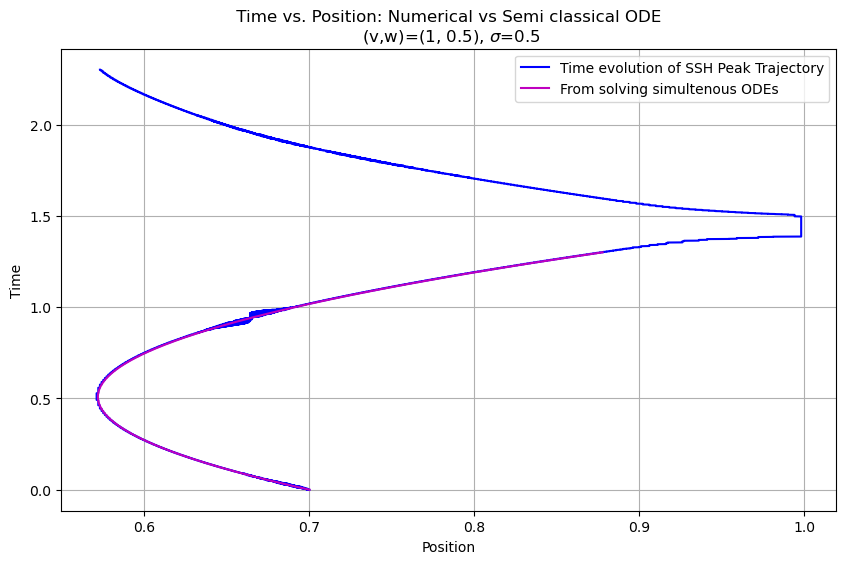

In [193]:
#CORRECT  !!!!!

import numpy as np 
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.integrate import solve_ivp

###############################################################################
# SSH Time Evolution (2D data only)
###############################################################################
def build_ssh_hamiltonian(N, v, w, sigma):
    H = np.zeros((N, N), dtype=complex)
    for i in range(N-1):
        v_i = v * ((i+1)/(N-1))**sigma
        w_i = w * ((i+1)/(N-1))**sigma
        if i % 2 == 0:
            H[i, i+1] = -v_i
            H[i+1, i] = -v_i
        else:
            H[i, i+1] = -w_i
            H[i+1, i] = -w_i
    return H

def gaussian_wave_packet(N, n0, p0, omega):
    n = np.arange(N)
    psi = np.exp(-0.5*((n-n0)/omega)**2) * np.exp(1j*p0*n)
    psi /= np.linalg.norm(psi)
    return psi

def run_ssh_2d(N, v, w, sigma, n0, p0, omega, dt, T):
    """
    Evolves an initial Gaussian wavepacket under the SSH Hamiltonian.
    Instead of plotting internally, this function returns the 2D data:
    the rescaled peak positions (x/N) and rescaled times (t/N).
    """
    H_SSH = build_ssh_hamiltonian(N, v, w, sigma)
    U = expm(-1j * H_SSH * dt)
    psi = gaussian_wave_packet(N, n0, p0, omega)
    t_steps = int(np.round(T/dt))
    psi_t = [np.abs(psi.copy())]
    
    for step in range(t_steps):
        psi = U @ psi
        psi_t.append(np.abs(psi))
        
    rescaled_positions = []
    rescaled_times = []
    for step, psi_abs in enumerate(psi_t):
        peak_index = np.argmax(psi_abs)
        t_val = step * dt
        rescaled_positions.append(peak_index / N)
        rescaled_times.append(t_val / N)
        
    return np.array(rescaled_positions), np.array(rescaled_times)

###############################################################################
# Modified SSH Model using ODE integration
###############################################################################
# Parameters
v_mod     = 1     
w_mod     = 0.5       
sigma_mod = 0.5       
x0        = 0.7      
p0_mod    = -0.3* np.pi/2  
t_span    = (0, p0_mod*(-4/np.pi)+2)   
max_step  = 0.001  

def t1_mod(x):
    return v_mod * (x**sigma_mod)
def t2_mod(x):
    return w_mod * (x**sigma_mod)
def dt1_dx_mod(x):
    return v_mod * sigma_mod * (x**(sigma_mod - 1.0))
def dt2_dx_mod(x):
    return w_mod * sigma_mod * (x**(sigma_mod - 1.0))

def modified_ssh_odes(t, y):
    x, p = y
    t1_val = t1_mod(x)
    t2_val = t2_mod(x)
    dt1_val = dt1_dx_mod(x)
    dt2_val = dt2_dx_mod(x)
    denom = np.sqrt(t1_val**2 + t2_val**2 + 2*t1_val*t2_val*np.cos(2*p))
    dxdt = (t1_val*t2_val*np.sin(2*p)) / denom
    ddx = (t1_val*dt1_val + t2_val*dt2_val + np.cos(2*p)*(dt1_val*t2_val + t1_val*dt2_val)) / denom
    dpdt = 0.5 * ddx
    return [dxdt, dpdt]

# Run the ODE integration
y0 = [x0, p0_mod]
sol = solve_ivp(modified_ssh_odes, t_span, y0, dense_output=True, max_step=max_step)
t_vals = sol.t       # Original time values from ODE solver
x_vals = sol.y[0]
t_vals_mod = t_vals / 2   # Modified time values (divided by 2)

###############################################################################
# Run the SSH simulation to get 2D data
###############################################################################
N = 1000
v = v_mod
w = w_mod
sigma = sigma_mod
n0 = x0*N
p0_ssh = p0_mod
omega = 25
dt = 0.1
T = N*p0_mod*(-2/np.pi)+2000

ssh_positions, ssh_times = run_ssh_2d(N, v, w, sigma, n0, p0_ssh, omega, dt, T)

#ANALYTICAL TURNING POINT

#x_min_analytic = x0 * (np.sqrt(v_mod**2 + w_mod**2 + 2*v_mod*w_mod*np.cos(2*p0_mod)) / (v_mod + w_mod))**(1/sigma_mod)
#x_min_analytic_label = f"Analytic x_min= {x_min_analytic:.3f}"
###############################################################################
# Combined Plot: 2D Comparison (Time vs. Position)
###############################################################################
plt.figure(figsize=(10,6))
plt.plot(ssh_positions, ssh_times, 'b-', label="Time evolution of SSH Peak Trajectory")
plt.plot(x_vals, t_vals_mod, 'm-', label="From solving simultenous ODEs")
plt.xlabel("Position")
plt.ylabel("Time")
plt.title(f" Time vs. Position: Numerical vs Semi classical ODE \n (v,w)={v,w}, $\sigma$={sigma}")
#plt.axvline(x=x_min_analytic, color='g', linestyle=':', label=x_min_analytic_label)
plt.legend()
plt.grid(True)
plt.show()


In [8]:
#zero energy eigen states peak location
import numpy as np

def build_ssh_hamiltonian(N, v, w, sigma):
    """
    Build the SSH Hamiltonian on a 1D lattice of N sites.
    """
    H = np.zeros((N, N), dtype=complex)
    for i in range(N-1):
        v_i = v * ((i + 1) / (N-1))**sigma
        w_i = w * ((i + 1) / (N-1))**sigma
        if i % 2 == 0:
            H[i, i+1] = -v_i
            H[i+1, i] = -v_i
        else:
            H[i, i+1] = -w_i
            H[i+1, i] = -w_i
    return H

def determine_peak_locations(N=1000, v=0.5, w=1, sigma=1, tol=1e-6):
    """
    Determine the exact site indices where the two zero-energy eigenstates 
    (extracted from the SSH Hamiltonian with (N, v, w, σ) = (1000, 0.5, 1, 1))
    have their maximum amplitude (i.e. their peaks).

    Returns:
        left_peak: site index of the left edge zero-energy eigenstate.
        right_peak: site index of the right edge zero-energy eigenstate.
    """
    # Build the Hamiltonian used for extraction.
    H = build_ssh_hamiltonian(N, v, w, sigma)
    
    # Diagonalize H to get eigenvalues and eigenstates.
    eigvals, eigvecs = np.linalg.eigh(H)
    
    # Find indices of eigenvalues close to zero.
    zero_indices = np.where(np.abs(eigvals) < tol)[0]
    if len(zero_indices) < 2:
        raise ValueError("Expected at least two zero-energy eigenstates, but found less.")
    
    # Get the two candidate eigenstates.
    psi_candidate1 = eigvecs[:, zero_indices[0]]
    psi_candidate2 = eigvecs[:, zero_indices[1]]
    
    # Determine the peak (maximum absolute amplitude) index for each state.
    peak1 = np.argmax(np.abs(psi_candidate1))
    peak2 = np.argmax(np.abs(psi_candidate2))
    
    # Assign left and right based on the peak positions.
    if peak1 < peak2:
        left_peak = peak1   # Left edge eigenstate (localized near index 0)
        right_peak = peak2  # Right edge eigenstate (localized near index N-1)
    else:
        left_peak = peak2
        right_peak = peak1
    
    return left_peak, right_peak

if __name__ == "__main__":
    left_peak, right_peak = determine_peak_locations()
    print("Left edge zero-energy eigenstate peak is at site index:", left_peak)
    print("Right edge zero-energy eigenstate peak is at site index:", right_peak)


Left edge zero-energy eigenstate peak is at site index: 0
Right edge zero-energy eigenstate peak is at site index: 999


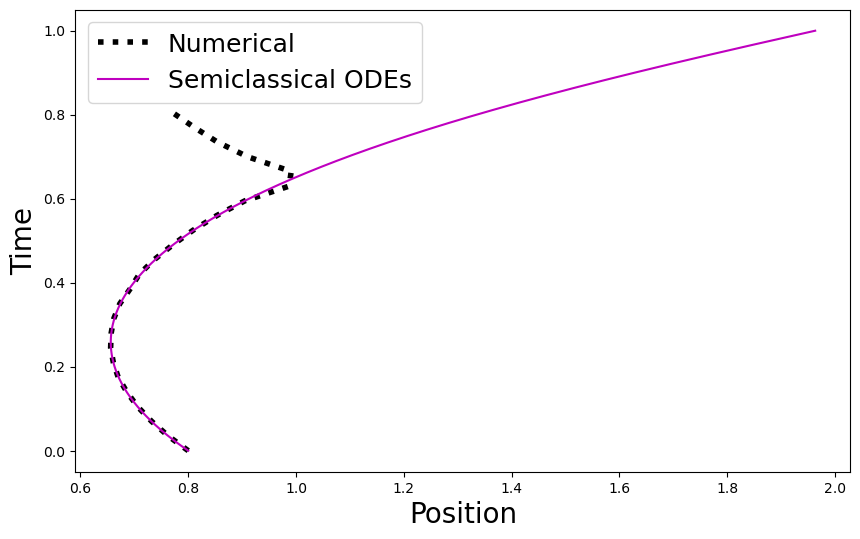

In [218]:
#CORRECT  !!!!!
#and you can tweak

import numpy as np 
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.integrate import solve_ivp

###############################################################################
# SSH Time Evolution (2D data only)
###############################################################################
def build_ssh_hamiltonian(N, v, w, sigma):
    H = np.zeros((N, N), dtype=complex)
    for i in range(N-1):
        v_i = v * ((i+1)/(N-1))**sigma
        w_i = w * ((i+1)/(N-1))**sigma
        if i % 2 == 0:
            H[i, i+1] = -v_i
            H[i+1, i] = -v_i
        else:
            H[i, i+1] = -w_i
            H[i+1, i] = -w_i
    return H

def gaussian_wave_packet(N, n0, p0, omega):
    n = np.arange(N)
    psi = (np.pi*omega**2)**(-0.25)*np.exp(-0.5*((n-n0)/omega)**2) * np.exp(1j*p0*n)
    psi /= np.linalg.norm(psi)
    return psi

def run_ssh_2d(N, v, w, sigma, n0, p0, omega, dt, T):
    """
    Evolves an initial Gaussian wavepacket under the SSH Hamiltonian.
    Instead of plotting internally, this function returns the 2D data:
    the rescaled peak positions (x/N) and rescaled times (t/N).
    """
    H_SSH = build_ssh_hamiltonian(N, v, w, sigma)
    U = expm(-1j * H_SSH * dt)
    psi = gaussian_wave_packet(N, n0, p0, omega)
    t_steps = int(np.round(T/dt))
    psi_t = [np.abs(psi.copy())]
    
    for step in range(t_steps):
        psi = U @ psi
        psi_t.append(np.abs(psi))
        
    rescaled_positions = []
    rescaled_times = []
    for step, psi_abs in enumerate(psi_t):
        peak_index = np.argmax(psi_abs)
        t_val = step * dt
        rescaled_positions.append(peak_index / N)
        rescaled_times.append(t_val / N)
        
    return np.array(rescaled_positions), np.array(rescaled_times)

###############################################################################
# Modified SSH Model using ODE integration
###############################################################################
# Parameters
v_mod     = 1      
w_mod     = 1.6       
sigma_mod = 1       
x0        = 0.8 
epsilon = 1e-8      
p0_mod    = -0.4*np.pi/2 + 0*epsilon 
#p0_mod    = -np.pi
#t_span    = (0, p0_mod*(-4/np.pi)+0.6 )  
t_span    =(0,1)
max_step  = 0.001  

def t1_mod(x):
    return v_mod * (x**sigma_mod)
def t2_mod(x):
    return w_mod * (x**sigma_mod)
def dt1_dx_mod(x):
    return v_mod * sigma_mod * (x**(sigma_mod - 1.0))
def dt2_dx_mod(x):
    return w_mod * sigma_mod * (x**(sigma_mod - 1.0))

def modified_ssh_odes(t, y):
    x, p = y
    t1_val = t1_mod(x)
    t2_val = t2_mod(x)
    dt1_val = dt1_dx_mod(x)
    dt2_val = dt2_dx_mod(x)
   # denom = np.sqrt(v_mod**2 + w_mod**2 + 2*v_mod*w_mod*np.cos(2*p0_mod))
    epsilon = 1e-20
    denom= np.sqrt(t1_val**2 + t2_val**2 + 2*t1_val*t2_val*np.cos(2*p))
    dxdt = 2*(t1_val*t2_val*np.sin(2*p)) / denom
    ddx = (t1_val*dt1_val + t2_val*dt2_val + np.cos(2*p)*(dt1_val*t2_val + t1_val*dt2_val)) / denom
    dpdt = ddx
    return [dxdt, dpdt]

# Run the ODE integration
y0 = [x0, p0_mod]
sol = solve_ivp(modified_ssh_odes, t_span, y0, dense_output=True, max_step=max_step)
t_vals = sol.t       # Original time values from ODE solver
x_vals = sol.y[0]
t_vals_mod = t_vals / 1   # Modified time values (divided by 2)

###############################################################################
# Run the SSH simulation to get 2D data
###############################################################################
N = 1000
v = v_mod
w = w_mod
sigma = sigma_mod
n0 = x0*N
p0_ssh = p0_mod
omega = 25
dt = 35
T = N*p0_mod*(-2/np.pi)+400

ssh_positions, ssh_times = run_ssh_2d(N, v, w, sigma, n0, p0_ssh, omega, dt, T)

#ANALYTICAL TURNING POINT

#x_min_analytic = x0 * (np.sqrt(v_mod**2 + w_mod**2 + 2*v_mod*w_mod*np.cos(2*p0_mod)) / (v_mod + w_mod))**(1/sigma_mod)
#x_min_analytic_label = f"Analytic x_min= {x_min_analytic:.3f}"
###############################################################################
# Combined Plot: 2D Comparison (Time vs. Position)
###############################################################################
plt.figure(figsize=(10,6))
plt.plot(ssh_positions, ssh_times, 'k:',linewidth=4,label="Numerical")
#plt.plot(x_vals, t_vals_mod, 'm-', label="Semiclassical ODEs")
plt.plot(x_vals,t_vals_mod, 'm-', label="Semiclassical ODEs")

plt.xlabel("Position", fontsize= 20)
plt.ylabel("Time", fontsize= 20)
#plt.title(f" Time vs. Position: Numerical vs Semi classical ODE \n (v,w)={v,w}, $\sigma$={sigma}")
#plt.axvline(x=x_min_analytic, color='black', linestyle='dashdot', label=x_min_analytic_label)
plt.legend(fontsize=18)
#plt.grid(True)
plt.show()


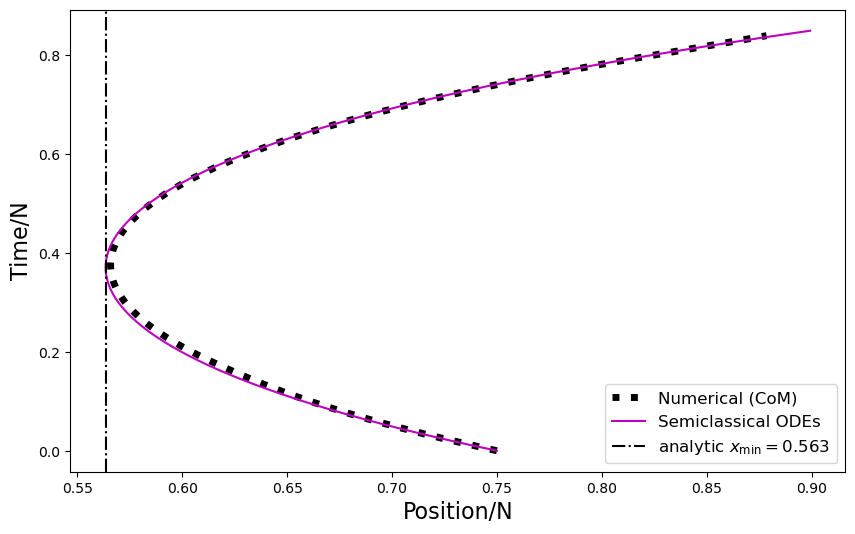

In [12]:
#CENTRE OF MASS OF WAVE PACKET
import numpy as np 
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.integrate import solve_ivp

###############################################################################
# SSH Time Evolution (2D data only)
###############################################################################
def build_ssh_hamiltonian(N, v, w, sigma):
    H = np.zeros((N, N), dtype=complex)
    for i in range(N-1):
        v_i = v * ((i+1)/(N-1))**sigma
        w_i = w * ((i+1)/(N-1))**sigma
        if i % 2 == 0:
            H[i, i+1] = -v_i
            H[i+1, i] = -v_i
        else:
            H[i, i+1] = -w_i
            H[i+1, i] = -w_i
    return H

def gaussian_wave_packet(N, n0, p0, omega):
    n = np.arange(N)
    psi = np.exp(-0.5*((n-n0)/omega)**2) * np.exp(1j*p0*n)
    psi /= np.linalg.norm(psi)
    return psi

def run_ssh_2d(N, v, w, sigma, n0, p0, omega, dt, T):
    """
    Evolves an initial Gaussian wavepacket under the SSH Hamiltonian.
    Instead of plotting internally, this function returns the 2D data:
    the rescaled *center of mass* positions (x/N) and rescaled times (t/N).
    """
    H_SSH = build_ssh_hamiltonian(N, v, w, sigma)
    U = expm(-1j * H_SSH * dt)
    psi = gaussian_wave_packet(N, n0, p0, omega)
    t_steps = int(np.round(T/dt))
    
    psi_t = [psi.copy()]  # store wavefunction (complex)
    
    for step in range(t_steps):
        psi = U @ psi
        psi_t.append(psi.copy())
        
    rescaled_positions = []
    rescaled_times = []
    
    for step, psi_cplx in enumerate(psi_t):
        psi_abs = np.abs(psi_cplx)
        
        # (CHANGED HERE!) Instead of np.argmax(psi_abs), compute the center of mass:
        n_array = np.arange(len(psi_abs))
        prob = psi_abs**2
        total_prob = np.sum(prob)
        if total_prob < 1e-15:
            # if the wavefunction is nearly empty, fallback to 0
            com_index = 0.0
        else:
            com_index = np.sum(n_array * prob) / total_prob
        
        t_val = step * dt
        # Store center of mass (com_index / N) as the "position"
        rescaled_positions.append(com_index / N)
        rescaled_times.append(t_val / N)
        
    return np.array(rescaled_positions), np.array(rescaled_times)

###############################################################################
# Modified SSH Model using ODE integration
###############################################################################
# Parameters
v_mod     = 1.0       
w_mod     = 1.45       
sigma_mod = 1.75       
x0        = .75 
epsilon = 1e-8      
p0_mod    = -0.6* np.pi/2 + epsilon 
t_span    = (0, p0_mod*(-4/np.pi)+0.5)   
max_step  = 0.001  

def t1_mod(x):
    return v_mod * (x**sigma_mod)
def t2_mod(x):
    return w_mod * (x**sigma_mod)
def dt1_dx_mod(x):
    return v_mod * sigma_mod * (x**(sigma_mod - 1.0))
def dt2_dx_mod(x):
    return w_mod * sigma_mod * (x**(sigma_mod - 1.0))

def modified_ssh_odes(t, y):
    x, p = y
    t1_val = t1_mod(x)
    t2_val = t2_mod(x)
    dt1_val = dt1_dx_mod(x)
    dt2_val = dt2_dx_mod(x)
    denom= np.sqrt(t1_val**2 + t2_val**2 + 2*t1_val*t2_val*np.cos(2*p))
    dxdt = (t1_val*t2_val*np.sin(2*p)) / denom
    ddx = (t1_val*dt1_val + t2_val*dt2_val + np.cos(2*p)*(dt1_val*t2_val + t1_val*dt2_val)) / denom
    dpdt = 0.5 * ddx
    return [dxdt, dpdt]

from scipy.integrate import solve_ivp
y0 = [x0, p0_mod]
sol = solve_ivp(modified_ssh_odes, t_span, y0, dense_output=True, max_step=max_step)
t_vals = sol.t       
x_vals = sol.y[0]
t_vals_mod = t_vals / 2   

###############################################################################
# Run the SSH simulation to get 2D data (Now using CoM)
###############################################################################
N = 1000
v = v_mod
w = w_mod
sigma = sigma_mod
n0 = x0*N
p0_ssh = p0_mod
omega = 25
dt = 0.1
T = N*p0_mod*(-2/np.pi)+240

ssh_positions, ssh_times = run_ssh_2d(N, v, w, sigma, n0, p0_ssh, omega, dt, T)

#ANALYTICAL TURNING POINT (example)
x_min_analytic = x0 * (np.sqrt(v_mod**2 + w_mod**2 + 2*v_mod*w_mod*np.cos(2*p0_mod)) / (v_mod + w_mod))**(1/sigma_mod)
x_min_analytic_label = fr"analytic $ x_{{\mathrm{{min}}}} = {x_min_analytic:.3f}$"

###############################################################################
# Combined Plot: 2D Comparison (Time vs. Position)
###############################################################################
plt.figure(figsize=(10,6))
plt.plot(ssh_positions, ssh_times, 'k:', linewidth=5, label="Numerical (CoM)")

plt.plot(x_vals, t_vals_mod, 'm-', label="Semiclassical ODEs")

plt.axvline(x=x_min_analytic, color='black', linestyle='dashdot', label=x_min_analytic_label)

plt.xlabel("Position/N", fontsize= 16)
plt.ylabel("Time/N", fontsize= 16)
plt.legend(fontsize=12)
plt.show()


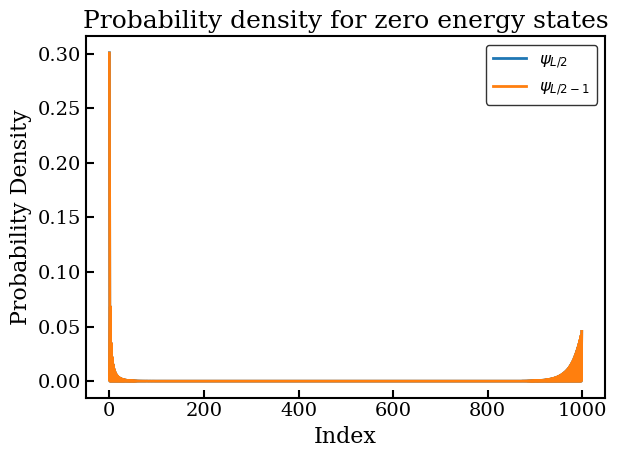

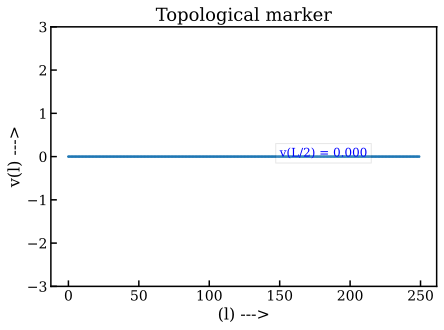

X[0,0] = -250.0
max(probability_density) = 0.30079168656758926
max(probability_density2) = 0.30048407909059294
Topological marker in bulk (sigma=1): 8.005223164827335e-30


In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Option A: To use LaTeX, you would need to install it in Colab.
# For simplicity, we disable LaTeX rendering:
mpl.rcParams.update({
    'text.usetex': False,         # Set to False to avoid LaTeX errors
    'font.family': 'serif',
    'font.size': 14,
    'axes.linewidth': 1.5,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5,
    'lines.linewidth': 2,
    'lines.markersize': 8,
    'legend.frameon': True,
    'legend.edgecolor': 'black',
    'legend.fontsize': 12,
})

L = 1000
sigma = 1  
w = 1.05
v_val = 1  # hopping amplitude

# Construct SSH Hamiltonian (L x L complex matrix)
SHH = np.zeros((L, L), dtype=complex)
for i in range(L - 1):
    v_i = v_val * ((i + 1) / (L - 1)) ** sigma
    w_i = w * ((i + 1) / (L - 1)) ** sigma
    if i % 2 == 0:
        SHH[i + 1, i] = v_i
        SHH[i, i + 1] = v_i
    else:
        SHH[i + 1, i] = w_i
        SHH[i, i + 1] = -w_i

eigenvalues, eigenvectors = np.linalg.eigh(SHH)

#------------------------------
# Plot probability density for eigenvectors at indices L//2 and L//2 - 1
prob_density  = np.abs(eigenvectors[:, L // 2]) ** 2
prob_density2 = np.abs(eigenvectors[:, L // 2 - 1]) ** 2

plt.figure()
plt.title("Probability density for zero energy states", fontsize=18)
plt.plot(np.arange(len(eigenvalues)), prob_density, label=r'$\psi_{L/2}$')
plt.plot(np.arange(len(eigenvalues)), prob_density2, label=r'$\psi_{L/2-1}$')
plt.xlabel('Index', fontsize=16)
plt.ylabel('Probability Density', fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()

#------------------------------
# Compute the topological marker using the reduced subspace

num_eigenvectors = len(eigenvalues)        # 1000
num_eigenvectors_half = num_eigenvectors // 2  # 500

# Construct reduced eigenvector matrices (shape: L x 500)
Um = eigenvectors[:, :num_eigenvectors_half]
Up = eigenvectors[:, num_eigenvectors_half:]

# Compute projection matrices in the reduced space (500 x 500)
trans_Um = Um.T
trans_Up = Up.T
Pp = trans_Up @ Up  # shape (500,500)
Pm = trans_Um @ Um  # shape (500,500)
Q = Pp - Pm         # shape (500,500)

# Define GA and GB as (500 x 500) diagonal matrices
GA = np.zeros((num_eigenvectors_half, num_eigenvectors_half))
GB = np.zeros((num_eigenvectors_half, num_eigenvectors_half))
for i in range(num_eigenvectors_half):
    if i % 2 == 0:
        GA[i, i] = 1
    else:
        GB[i, i] = 1

# Compute Qab and Qba in reduced space
Qab = GA @ Q @ GB
Qba = GB @ Q @ GA

# Define reduced X (500 x 500)
X = np.zeros((num_eigenvectors_half, num_eigenvectors_half))
X[0, 0] = -L / 4  # -250
for i in range(num_eigenvectors_half):
    if i % 2 == 0:
        X[i, i] = -L / 4 + i / 2
        if i + 1 < num_eigenvectors_half:
            X[i + 1, i + 1] = X[i, i]

# Compute v1 and v2; take the real part to discard negligible imaginary parts
v1 = 0.5 * (Qba @ (X @ Qab - Qab @ X))
v2 = 0.5 * (Qab @ (Qba @ X - X @ Qba))
v1 = np.real(v1)
v2 = np.real(v2)

# Compute topological marker v over pairs in the reduced space.
num_pairs = num_eigenvectors_half // 2  # 500/2 = 250
v_marker = np.zeros(num_pairs)
for i in range(num_pairs):
    idx1 = 2 * i
    idx2 = idx1 + 1
    v_marker[i] = v1[idx1, idx1] + v1[idx2, idx2] + v2[idx1, idx1] + v2[idx2, idx2]

plt.figure()
%config InlineBackend.figure_format = 'svg'
plt.title("Topological marker", fontsize=18)
plt.xlabel("(l) --->", fontsize=16)
plt.ylabel("v(l) --->", fontsize=16)
plt.scatter(np.arange(len(v_marker)), v_marker, s=3)
plt.ylim(-3, 3)
v_middle = v_marker[len(v_marker) // 2]
plt.text(0.6 * len(v_marker), v_middle, f"v(L/2) = {v_middle:.3f}",
         fontsize=12, color='blue', bbox=dict(facecolor='white', alpha=0.1))
plt.tight_layout()
plt.show()

# Diagnostics:
print("X[0,0] =", X[0, 0])
print("max(probability_density) =", np.max(prob_density))
print("max(probability_density2) =", np.max(prob_density2))
print(f"Topological marker in bulk (sigma={sigma}):", v_marker[len(v_marker) // 2])
